In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import numpy.random as rn
import networkx as nx
import my_networkx as my_nx

mpl.rcParams.update({'font.size': 18})


In [2]:
A = np.array([[0, 1, 0, 0, 0, 0],[1, 0, 1, 0, 1, 0],[0, 1, 0, 1, 0, 0],[0, 0, 1, 0, 1, 0],[0, 1, 0, 1, 0, 1],[0, 0, 0, 0, 1, 0]])
print(A)

[[0 1 0 0 0 0]
 [1 0 1 0 1 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 1]
 [0 0 0 0 1 0]]


In [137]:
def plot_network(A, we=np.ones_like(A), position={1:(0,0),2:(1,0),3:(2,1),4:(3,0),5:(2,-1),6:(2,0)}, name="figures/Example_Calmodulin_1.pdf", node_color=np.ones(len(A)), edge_name="r"):
    
    G = nx.DiGraph() 
    edges = []
    k = 0
    color = []
    N = len(A[:,0])
    for i in range(len(A[:,0])): 
        for j in range(len(A[:,0])): 
            if we[i, j] > 0 and we[j, i] > 0: 
                #G.add_edge(i,j)
                if edge_name == "r":
                    edges.append((i+1, j+1, {"weight":we[i,j], "w":r"$r_{%d%d}$" % (j+1, i+1)}))
                elif edge_name == "j":
                    edges.append((i+1, j+1, {"weight":we[i,j], "w":r"$p_{%d}r_{%d%d}$" % (j+1, j+1, i+1)}))
                color.append(we[i,j])

        G.add_node(i+1)

    G.add_edges_from(edges)

    weights = [10*G[u][v]['weight'] for u,v in G.edges]

    fixed_positions = position #dict with two of the positions set
    fixed_nodes = fixed_positions.keys()
    pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)

    cmap = plt.cm.plasma

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), gridspec_kw={'width_ratios': [1, 3]})
    plt.tight_layout()

    nx.draw_networkx_nodes(G, pos, ax=ax[1], node_size=3000, edgecolors="k")
    nx.draw_networkx_labels(G, pos, ax=ax[1], font_size=30)

    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, ax=ax[1], edgelist=straight_edges, arrowstyle="<|-", width=5, node_size=3000)
    arc_rad = 0.15
    edges_plot = nx.draw_networkx_edges(G, pos, ax=ax[1], edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}', arrowstyle="<|-", width=weights, edge_color=weights, arrowsize=20, node_size=3000)

    pc = mpl.collections.PatchCollection(edges_plot, cmap=cmap)
    pc.set_array(weights)

    edge_weights = nx.get_edge_attributes(G,'w')
    curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
    my_nx.my_draw_networkx_edge_labels(G, pos, ax=ax[1], edge_labels=curved_edge_labels,rotate=False,rad = arc_rad, font_size=20)
    nx.draw_networkx_edge_labels(G, pos, ax=ax[1], edge_labels=straight_edge_labels,rotate=False)
    plt.colorbar(pc, ax=ax[1])
    
    ax[0].bar(np.arange(1, N+1), node_color, width=np.ones(N)*0.8, color="green", align="center", edgecolor="black")
    ax[0].set_xlabel(r"State $i$")
    ax[0].set_ylabel(r"$p_i$")
    ax[0].grid()
    ax[0].set_xticks(np.arange(1, N+1))
    
    plt.savefig(name, dpi=500, bbox_inches="tight")

In [4]:
def printMatrix(s):
    
    for i in range(len(s)):
        for j in range(len(s[0])):
            print("%f   " % (s[i][j]), end="")
        print("\n") 

In [5]:
def Matrices(energies, A):
    N = len(energies)
    peq = np.exp(-energies)
    Z = np.sum(peq)
    peq = peq/Z
    # Probability matrix
    Pmatrix = np.zeros((N, N))
    for i in range(N):
        Pmatrix[i, i] = np.sqrt(peq[i])

    #Master operator DB
    L = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if A[i, j] == 1:
                L[i, j] = np.exp((energies[j]-energies[i])/2)
    for i in range(N):
        L[i, i] = - np.sum(L[:, i])
    # Symmetrised Master op DB
    Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))

    return Pmatrix, L, Ls, peq




## Four state system

In [13]:
def AntiSymmetric(Adj, energies, A):

    N = len(energies)
    Peq, L, Ls, peq = Matrices(energies=energies, A=Adj)
    EWs, EVs = np.linalg.eigh(Ls)
    D = np.diag(EWs)

    A = np.outer(EVs[:, 0], EVs[:, 1]) - np.outer(EVs[:, 1], EVs[:, 0])
    A = A * 0.01
    print("+++++++++++++++++++++++++++++++++++++++")
    printMatrix(A)
    print("+++++++++++++++++++++++++++++++++++++++")
    sqrtLs = np.matmul(EVs, np.matmul(np.diag(np.sqrt(np.abs(EWs))), EVs.T)) 
    Lneq = -np.matmul(sqrtLs, np.matmul(np.identity(N) + A, sqrtLs))

    Lneq_MO = np.matmul(Peq, np.matmul(Lneq, np.linalg.inv(Peq)))

    return Lneq_MO, peq, L  

## Algebraic approach

In [119]:
def L_full(A: np.ndarray, E: np.ndarray, w: np.ndarray):
    """_summary_

    Args:
        A (np.ndarray): Adjecency matrix, NxN. Needed to leave structure the same.
        E (np.ndarray): Energies of states, N. For invariant probability measure and transition rates.
        w (np.ndarray): Weighting of antisymmetric edges, NxN. Has to be antisymmetric with entries < 1. 

    Returns:
        np.ndarray: Full master operator
        np.ndarray: Steady state probability vector
        np.ndarray: Antisymmetric part
        np.ndarray: Symmetric part
    """


    L = np.zeros_like(A)

    # probability vector
    peq = np.exp(-E) / np.sum(np.exp(-E))

    # size of system
    N = len(E)
    
    # symmetric part of master operator
    Ls = np.zeros((N, N))
    # off-diagonal entries
    for i in range(N):
        for j in range(N):
            # check for edge
            if A[i, j] == 1:
                Ls[i, j] = np.exp((E[j] - E[i])/2)
                # Ls[j, i] = np.exp((E[i] - E[j])/2)
        
    # diagonal entries
    for i in range(N):
        Ls[i, i] = -np.sum(Ls[:, i])
    
    


    # antisymmetric part
    La = np.zeros((N, N))
    # only has off-diagonal entries
    for i in range(N):
        for j in range(N):
            # check for edge
            if A[i, j] == 1:
                La[i, j] = w[i, j]* np.exp(E[j])

    # full master operator is sum of symmetric and antisymmetric part    
    L = La + Ls


    # LL = np.zeros((N, N))

    # for i in range(N):
    #     for j in range(N):
    #         if A[i, j] == 1:
    #             LL[i, j] = np.exp((E[j]-E[i])/2) + w[i, j] * np.exp(E[j])
    # for i in range(N):
    #     LL[i,i] = -np.sum(LL[:, i])

    # printMatrix(LL)

    # print("###################")
    # printMatrix(L)

    # print(np.linalg.eig(L)[0])
    # print(np.linalg.eig(LL)[0])

    return L, peq, La, Ls

In [120]:
# Four state example
Adj = np.array([[0, 1, 1, 0], [1, 0, 1, 0], [1, 1, 0, 1], [0, 0, 1, 0]])

Energies = rn.uniform(low=0.0, high=3.0, size=(4))





In [142]:
E = np.array([np.exp(-(Energies[0] + Energies[1]) / 2), np.exp(-(Energies[0] + Energies[2]) / 2), np.exp(-(Energies[2] + Energies[1]) / 2)])

e = min(E)

Weight = np.array([[0, e/2, -e/2, 0], [-e/2, 0, e/2, 0], [e/2, -e/2, 0, 0], [0, 0, 0, 0]])

L, p, La, Ls = L_full(Adj, Energies, Weight)

In [143]:
current_s = np.zeros((4, 4))
current = np.zeros((4, 4))


for i in range(4):
    for j in range(4):
        if Adj[i, j] == 1:
            current_s[i, j] = p[i] * Ls[j, i]
            current[i, j] = p[i] * L[j, i]

pos = {1:(0, 0), 2:(0.5, 1.5), 3:(1, 0), 4:(1, 1.5)}



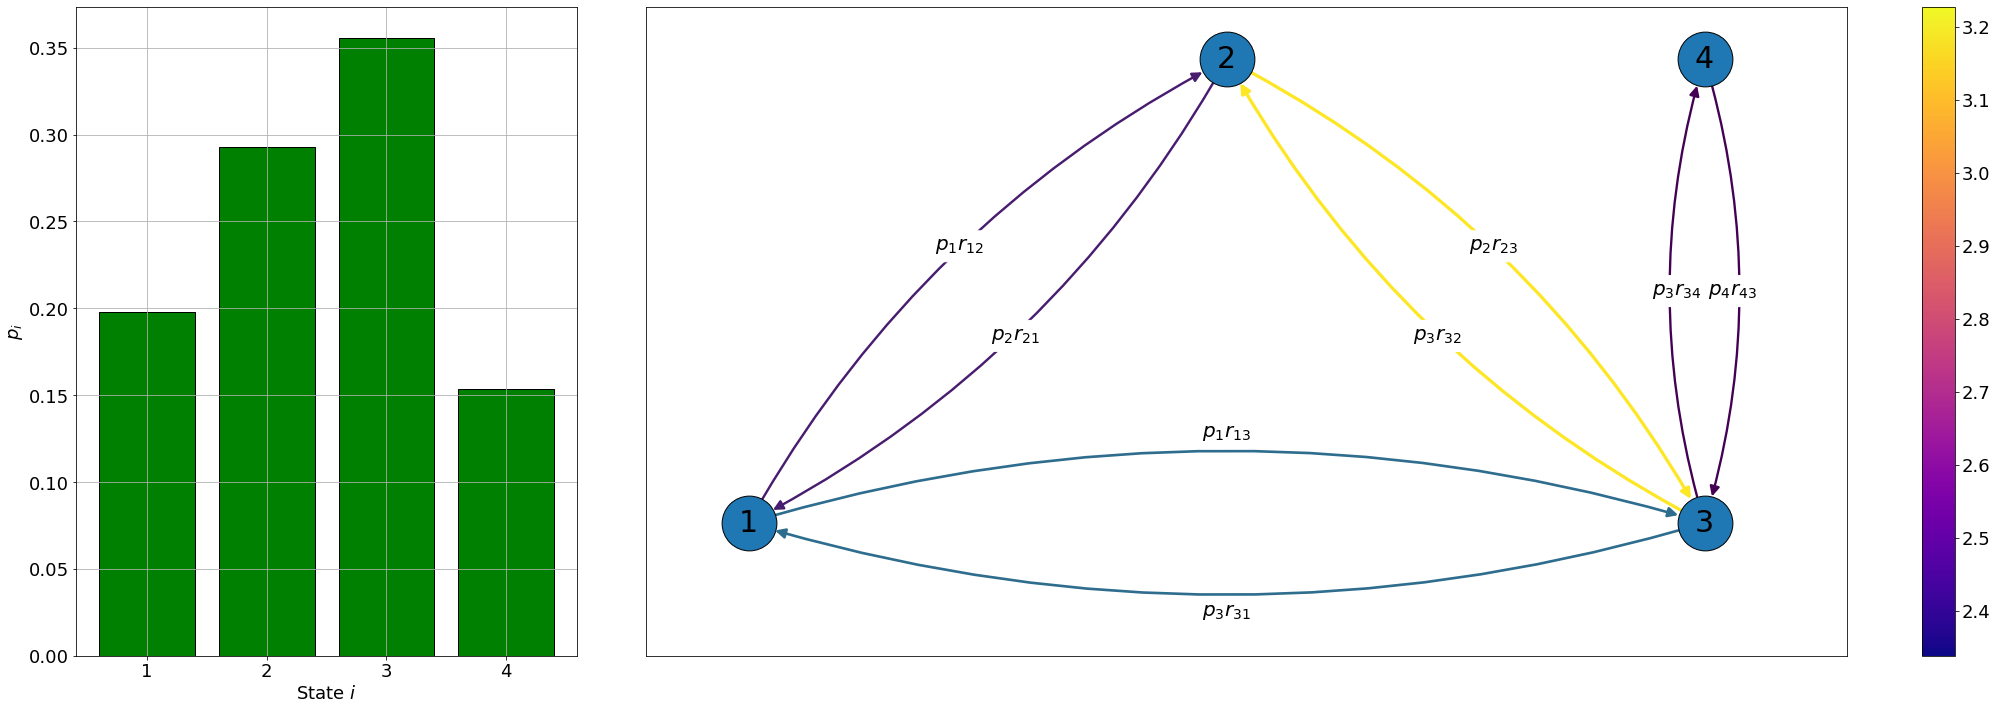

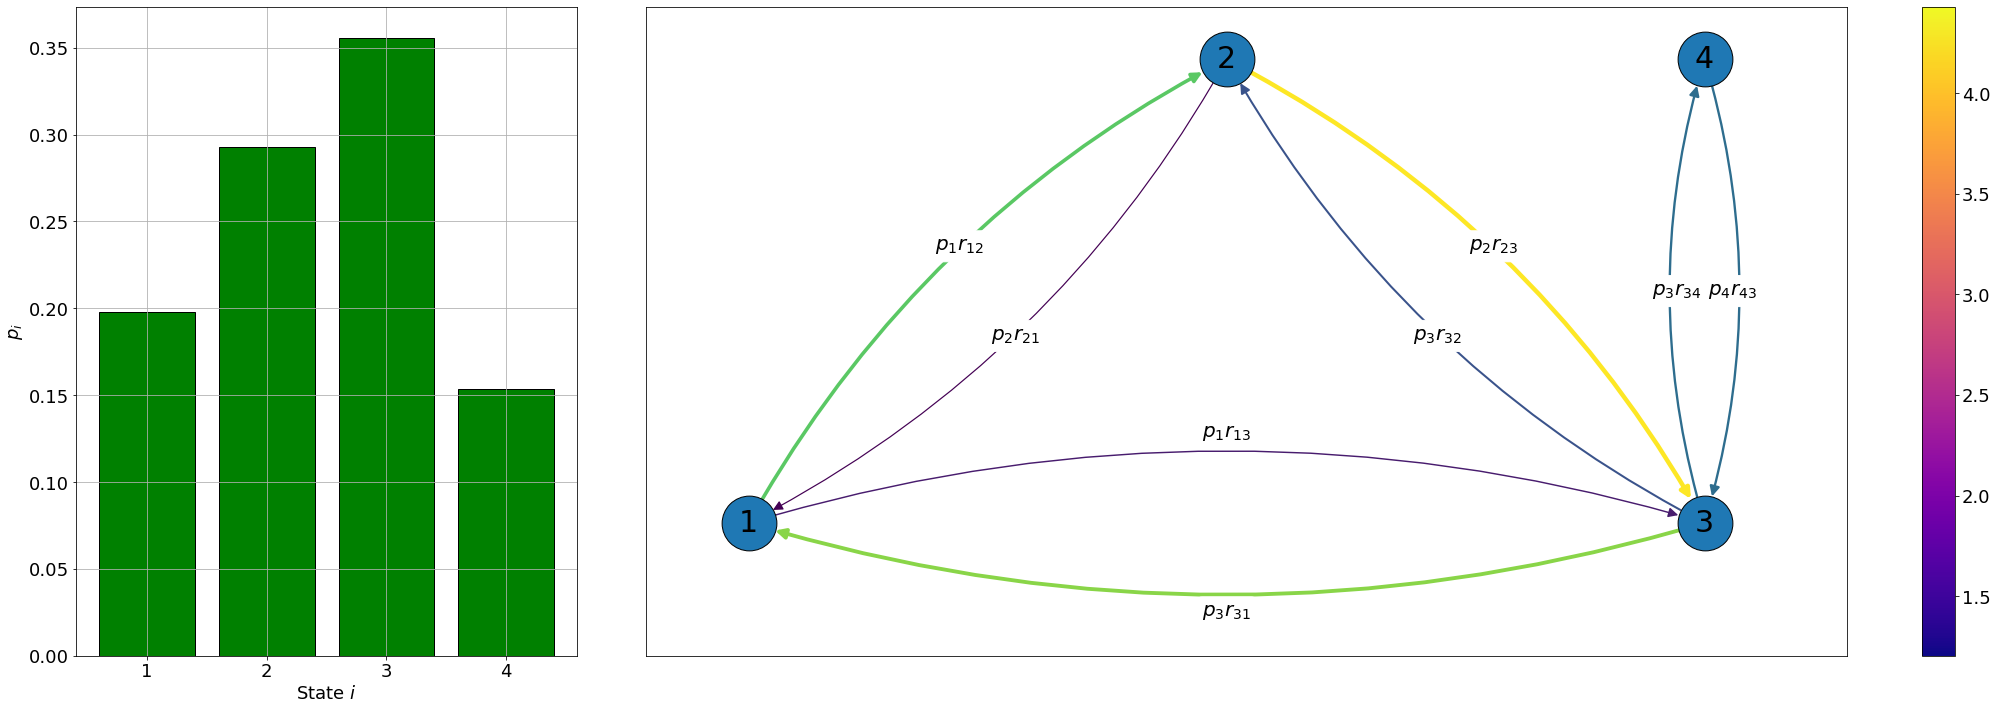

In [144]:
plot_network(Adj, we=current_s, position=pos, name="figures/4state_eq", node_color=p, edge_name="j")
plot_network(Adj, we=current, position=pos, name="figures/4state_neq", node_color=p, edge_name="j")